In [1]:
import numpy as np
import pandas as pd
from itertools import permutations
import math
from math import floor, ceil
import seaborn as sns
from matplotlib import pyplot as plt

import logging
logging.basicConfig(level='INFO')
mlogger = logging.getLogger('matplotlib')
mlogger.setLevel(logging.WARNING)

## Define the metrics

In [2]:
from metrics import infeasible_index, dcg, ndcg, KT

## Define the algorithms

#### Mallows

For the Mallows algorithm, we use the code at https://github.com/ekhiru/top-k-mallows with slight changes

(I tried packaging their code, but the local imports wouldn't work, so I changed any `import LOCAL_FILE` to `from . import LOCAL_FILE`)

In [3]:
from mallows.mallows_kendall import sample as mk_sample

If `theta=0`, sample a permutation from a uniform distribution, otherwise use the Mallows code.

In [4]:
def mallows_sample(theta: float, s0: pd.DataFrame, m: int=1):
  if theta == 0:
    rng = np.random.default_rng()
    return [s0.loc[rng.permutation(s0.index)] for _ in range(m)]
  else:
    n = len(s0)
    center_ind = np.arange(n)
    sample = mk_sample(m=m, n=n, theta=theta, s0=center_ind)
    return [s0.iloc[ind] for ind in sample]

#### ILP


In [5]:
# import cvxpy as cp
# import pip
# if not ('SCIP' in cp.installed_solvers()):
#   pip.main(['install', 'cvxpy[SCIP]'])
# cp.installed_solvers()

## IMPORTANT: If a solver is installed, but you see a "Solver _____ is not installed"
## error in the next cell, restart the session and run again

from ilp.ilp import prepare_items, linprog_alg

#### DetConstSort


Algorithm described in https://arxiv.org/abs/1905.01989

In [6]:
def linkedin_alg(items: pd.DataFrame,
                 groups: list[dict],
                 target_prop: dict | list,
                 score_label: str,
                 r: int,
                #  s_label: str,
                 noise_rng: np.random.Generator=None,
                 noise_mean: float=None,
                 noise_var: float=None):
  """
    DetConstSort algorithm: given a set of items, their group memberships and scores, and a set of target representation values,
    return a ranking of length r that sorts the items by the scores while satisfying the target representation constraints. 
  """
  rankedItems, maxIndices = [], []
  item_groups = []
  for group in groups:
     q = ' & '.join(
                    [f'{s_i}=="{v_i}"' if isinstance(v_i, str) else f'{s_i}=={v_i}'
                     for s_i, v_i in group.items()]
                     )
     item_groups.append(items.query(q))
  n_groups = len(target_prop)
  group_counts, min_counts = [0] * n_groups, [0] * n_groups
  lastEmpty, k = 0, 0
  while lastEmpty < r:
    k+=1
    # determine the minimum feasible counts of each group at current rec. list size
    min_counts_at_k = [
        math.floor(p_gi*k) + (noise_rng.normal(noise_mean,noise_var) if noise_rng is not None else 0)
        for p_gi in target_prop]
    # get sensitive attr. values for which the current minimum count has increased
    # since last one
    changed_mins = []
    for group_idx in range(n_groups):
      if min_counts_at_k[group_idx] > min_counts[group_idx]:
        changed_mins.append(group_idx)
    if len(changed_mins) > 0:
      # get the list of candidates to insert and sort them by their score
      changed_items = []
      # save the candidate AND the index of the group it belongs to
      for group_idx in changed_mins:
        if group_counts[group_idx] < len(item_groups[group_idx]):
          changed_items.append((group_idx, item_groups[group_idx].iloc[group_counts[group_idx]]))
      changed_items.sort(key=lambda x: x[1][score_label],reverse=True)
      # add the candidate items, starting with the best score
      for newitem in changed_items:
        if len(rankedItems) == r:
          break
        maxIndices.append(k-1)
        rankedItems.append(newitem[1])
        start = lastEmpty
        while start > 0 and maxIndices[start-1] >= start and rankedItems[start-1][score_label] < rankedItems[start][score_label]:
          maxIndices[start-1], maxIndices[start] = maxIndices[start], maxIndices[start-1]
          rankedItems[start-1], rankedItems[start] = rankedItems[start], rankedItems[start-1]
          start -= 1
        lastEmpty+=1
        group_counts[newitem[0]] += 1
      min_counts = min_counts_at_k
  return pd.DataFrame(rankedItems)

#### ApproxMultiValuedIPF

Algorithm described in https://dl.acm.org/doi/pdf/10.1145/3514221.3517865

In [7]:
import networkx as nx
import math
import numpy as np

def ApproxMultiValuedIPF(data, pr_attr_name, score_attr_name, r, noise_rng=None, noise_mean=None, noise_var=None):
    sens_attr = list(data[pr_attr_name])
    score = list(data[score_attr_name])
    candidateId = list(data.index)

    allGenre = []
    group = []
    groupId = []
    for g in sens_attr:
        if g not in allGenre:
            allGenre.append(g)
        groupId.append(allGenre.index(g))

    all_items = []
    for i in range(0,len(candidateId)):
        all_items.append((score[i],candidateId[i],groupId[i]))

    all_items.sort(reverse=True)

    rank = []
    i = 1
    group = []
    # rank: position of each candidate in the ranking, starting from 1
    # group: group of that candidate
    for item in all_items:
        rank.append(i)
        group.append(item[2])
        i += 1

    rank = rank[:r]
    group = group[:r]

    numberOfItems = len(rank)
    rankGrp = {}
    # group of element on rank i
    for i in range(0, len(rank)):
        rankGrp[rank[i]] = group[i]

    grpCount = {}
    for i in group:
        grpCount[i] = 0

    rankGrpPos = {}
    # count of group of each candidate up to its position
    for i in rank:
        grpCount[rankGrp[i]] = grpCount[rankGrp[i]] + 1
        rankGrpPos[i] = grpCount[rankGrp[i]]

    rankRange = {}
    for item in rank:
        i = rankGrpPos[item]
        n = numberOfItems
        fp = grpCount[rankGrp[item]]
        r1 = math.floor((i-1) * n / fp)+1
        r2 = math.ceil(i * n / fp)
        if r2 > numberOfItems:
            r2 = numberOfItems
        rankRange[item] = (r1, r2)

    B = nx.Graph()
    top_nodes = []
    bottom_nodes = []

    for i in rank:
        top_nodes.append(i)
        bottom_nodes.append(str(i))
    B.add_nodes_from(top_nodes, bipartite=0)
    B.add_nodes_from(bottom_nodes, bipartite=1)

    for i in rank:
        r1, r2 = rankRange[i]
        for j in range(1, numberOfItems + 1):
            if j >= r1 and j <= r2:
                B.add_edge(i, str(j), weight=abs(i - j) + 0 if noise_rng is None else noise_rng.normal(noise_mean, noise_var))
            else:
                B.add_edge(i, str(j), weight=1000000000000)

    my_matching = nx.algorithms.bipartite.minimum_weight_full_matching(B, top_nodes, "weight")

    old_idx = list(data.index)
    new_idx = np.zeros(len(my_matching)//2)
    i=0
    for old_i, new_i in my_matching.items():
        new_idx[int(new_i) - 1] = old_idx[old_i-1]
        # res.iloc[int(new_idx)-1] = df.iloc[old_idx-1]
        i+=1
        if i == r:
            break
    res = data.loc[new_idx].copy()

    return res

## Experiment 1: Start from InfInd

In this experiment, we analyze a scenario of ten individuals, who belong to two equal-sized groups and create multiple rankings, by adjusting the placement of candidates from each group to produce diverse values of the Infeasible Index (II). We then sample rankings from a Mallows distribution using the initial ranking as the central permutation and varying values of θ, observing the resulting Infeasible Index in the samples.

In [13]:
theta_range = np.arange(2.26, step=0.25)
group_sizes = [5,5]
prop = {0: 0.5, 1: 0.5}
n = np.sum(group_sizes)
n_mallows_samples = 20

Generate centers (randomly sample until we get one with correct II).

With 2 equally sized groups, there's only one group structure for each II value.

In [14]:
s1 = ['a']*5
s2 = ['b']*5
center = pd.Series(s1+s2)
samples = mallows_sample(theta=0, s0=center, m=100)
n_center_samples = 1
ii_samples = {}
ii_samples_group_struct = {}

for s in samples:
    group_structure = (samples[0] == 'b').to_numpy()
    ii = infeasible_index(pd.DataFrame(s,columns=['sens']), [{'sens':'a'}, {'sens': 'b'}], target_prop=[0.5,0.5])
    if ii in ii_samples.keys():
        for smpl_gs in ii_samples_group_struct[ii]:
            if (group_structure == smpl_gs).all():
                break
            else:
                ii_samples[ii].append(s.index)
                ii_samples_group_struct[ii].append(group_structure)
    else:
        ii_samples[ii] = []
        ii_samples[ii].append(s.index)
        ii_samples_group_struct[ii] = []
        ii_samples_group_struct[ii].append(group_structure)

Run the experiment: sample the Mallows distribution centered on each of the initial rankings

In [15]:
mallows_results = pd.DataFrame(index=pd.MultiIndex.from_product([
    theta_range,
    range(max(ii_samples.keys())+1),
    range(n_center_samples),
    range(n_mallows_samples)]),columns=['ii'])

for theta in theta_range:
    for center_ii in ii_samples.keys():
        for i_c, center_sample in enumerate(ii_samples[center_ii][:n_center_samples]):
            samples = mallows_sample(theta=theta, s0=center.loc[center_sample], m=40)
            for i_s ,sample in enumerate(samples):
                ii = infeasible_index(
                    pd.DataFrame(sample,columns=['sens']), [{'sens':'a'}, {'sens': 'b'}], target_prop=[0.5,0.5])
                mallows_results.loc[theta, center_ii, i_c, i_s] = ii

In [16]:
mallows_results.index.set_names(['theta', 'StartInfInd', 'Center Sample', 'Rerank Sample'], inplace=True)
mallows_results_di = mallows_results.reset_index()
mallows_results_di

,theta,StartInfInd,Center Sample,Rerank Sample,ii
0,0.00,0,0,0,1
1,0.00,0,0,1,2
2,0.00,0,0,2,5
3,0.00,0,0,3,3
4,0.00,0,0,4,4
...,...,...,...,...,...
3195,2.25,0,0,35,0
3196,2.25,0,0,36,0
3197,2.25,0,0,37,1
3198,2.25,0,0,38,0


In [20]:
mallows_results_di['ii'] = mallows_results_di['ii'].astype(int)

mallows_results_di['Infeasible Index'] = mallows_results_di['ii']
mallows_results_di['Theta'] = mallows_results_di['theta']
mallows_results_di['Starting Infeasible Index'] = mallows_results_di['StartInfInd']
mallows_results_di['Start % Pfair Positions'] = 100 - (mallows_results_di['StartInfInd']/n*100)
mallows_results_di['% Pfair Positions'] = 100 - (mallows_results_di['ii']/n*100)

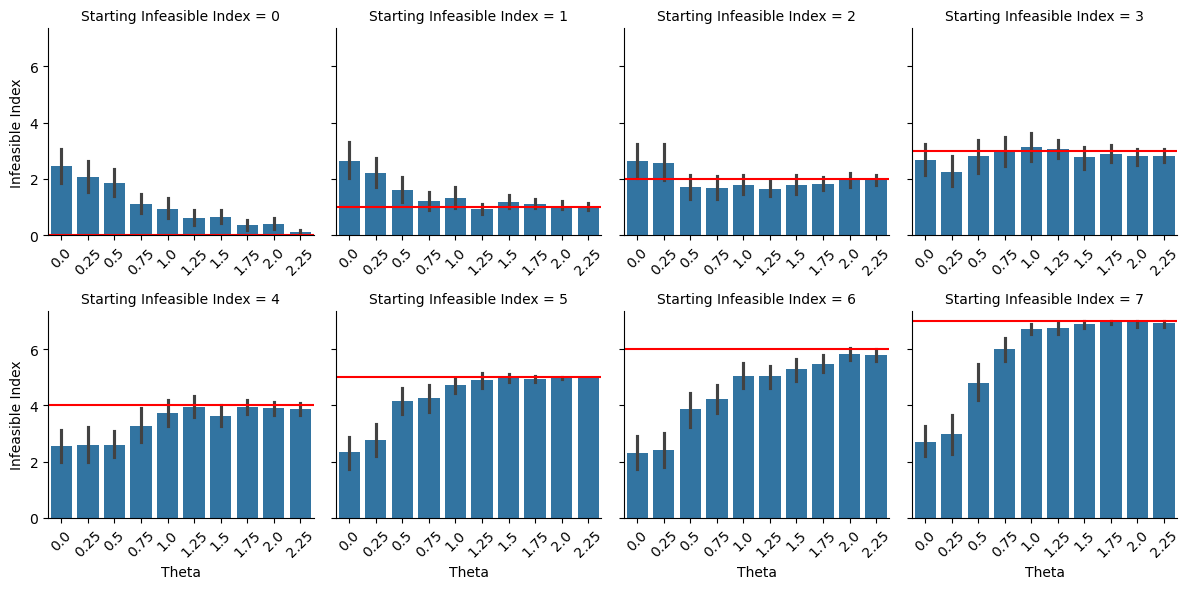

In [22]:
gr = sns.FacetGrid(data=mallows_results_di, col='Starting Infeasible Index',col_wrap=4,sharex=False)
gr.map(sns.barplot, 'Theta', 'Infeasible Index', order=theta_range)
for i in range(8):
    gr.facet_axis(0,i).axhline(y=i,c='red')
    gr.facet_axis(0,i).tick_params(axis='x',labelrotation=45)

gr.tight_layout()

## Experiment 2: Uniform Random Scores

In this experiment, we consider two equal-sized groups of five individuals each, where the candidates in the first group are assigned scores $S_1∼𝒰⁢(0,1)$, and in the second group - $S_2∼𝒰⁢(0+δ,1+δ)$, where $δ={0.0,0.1,…,0.9,1.0}$. We sort the rankings according to the descending candidate scores and sample the Mallows distribution centered on the sorted rankings with difference values of $θ$. We evaluate the Infeasible Index and NDCG of the samples.

In [23]:
### helper function
def calc_stats(ranking, center, groups, prop, score_label):
  ii = infeasible_index(ranking, groups, prop)
  ndcg = ndcg(ranking[score_label], center[score_label])
  # ndcg = dcg(ranking[score_label]/dcg(center[score_label]))
  return ndcg, ii

mean_range = [0, 2, 4, 8]
theta_range = np.arange(2.26, step=0.25)
vars = [2,2]
group_sizes = [5,5]
prop = {0: 0.5, 1: 0.5}
n = np.sum(group_sizes)

n_center_samples = 30
n_mallows_samples = 20


def make_group(loc, scale, size, name, rng, distr='normal'):
  if distr == 'normal':
    scores = rng.normal(loc=loc, scale=scale, size=size)
  elif distr == 'unif':
    scores = rng.uniform(low=loc, high=scale, size=size)
  return pd.DataFrame(data={'score': pd.Series(scores), 'group': pd.Series([name]*size)})

def make_sample(means, vars, group_sizes, rng, distr='normal'):
  groups = []
  for mean, var, size, gname in zip(means, vars, group_sizes, range(len(means))):
    groups.append(make_group(loc=mean, scale=var, size=size, name=gname, rng=rng, distr=distr))
  sample = pd.concat(groups,ignore_index=True).sort_values(inplace=False,ascending=False,by='score')
  sample['score'] = (sample['score'] - sample['score'].min())/(sample['score'].max() - sample['score'].min())
  return sample.sort_values(by='score', ascending=False)

Generate the data and run the experiment:

In [25]:
a1 = 0
b1 = 1

rng = np.random.default_rng(seed=0)

groups = [{'group': 0},{'group': 1}]
prop = [0.5,0.5]
r_ = n

a_range = np.arange(0, 1.1, step=0.1)
b_range = np.arange(1, 2.1, step=0.1)
cols = ['NDCG', 'InfeasibleIndex']

res_mallows_u = pd.DataFrame(index=pd.MultiIndex.from_product(
    [a_range, range(n_center_samples), theta_range,range(n_mallows_samples)],
    names=['a2', 'center_sample','theta','mallows_sample']), columns=cols)
init_ii_u = pd.Series(index=pd.MultiIndex.from_product([a_range, range(n_center_samples)]))

for a2, b2 in zip(a_range, b_range):
    # print(f'calculating for: {(a1, b1)}; {(a2, b2)}')
    for c_i in range(n_center_samples):
      center = make_sample([a1,a2], [b1,b2], group_sizes, rng,distr='unif')
      init_ii_u.loc[a2, c_i] = infeasible_index(center, groups, prop)
      for theta in theta_range:
        mallows_samples = mallows_sample(theta=theta, s0=center, m=n_mallows_samples)
        for sample_n in range(n_mallows_samples):
          sample_ii = infeasible_index(mallows_samples[sample_n], groups, prop)
          sample_ndcg = dcg(mallows_samples[sample_n]['score']/dcg(center['score']))
          res_mallows_u.loc[(a2,c_i,theta,sample_n),'InfeasibleIndex'] = sample_ii
          res_mallows_u.loc[(a2,c_i,theta,sample_n),'NDCG'] = sample_ndcg

res_mallows_u.to_csv('res_mallows_u.csv')

In [26]:
init_ii_u = init_ii_u.reset_index()

C:\Users\andre\AppData\Local\Temp\ipykernel_13240\796879741.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.set_xticklabels(np.round(a_range, decimals=2))


Text(0, 0.5, 'Mean InfeasibleIndex')

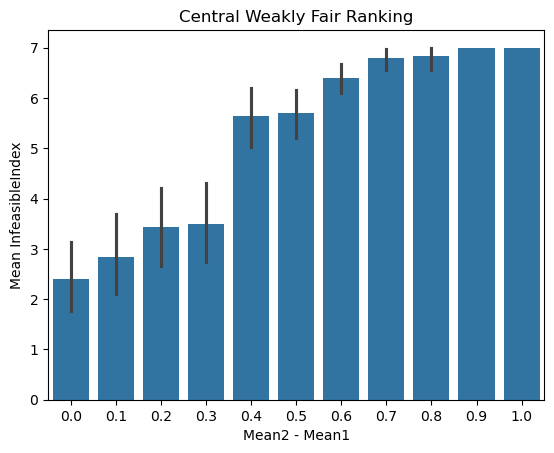

In [27]:
f = sns.barplot(data=init_ii_u, x='level_0', y=0)
f.set_title('Central Weakly Fair Ranking')
f.set_xticklabels(np.round(a_range, decimals=2))
# f.tick_params(axis='x',labelrotation=90)
f.set_xlabel('Mean2 - Mean1')
f.set_ylabel('Mean InfeasibleIndex')

In [28]:
init_ii_u['%Pfair'] = 100 - init_ii_u[0]/n*100

In [29]:
res_mallows_u = pd.read_csv('res_mallows_u.csv')
res_mallows_u['Difference in Means'] = np.round(res_mallows_u['a2'],1)
res_mallows_u['Infeasible Index'] = res_mallows_u['InfeasibleIndex'] 
res_mallows_u['Theta'] = res_mallows_u['theta']
res_mallows_u['% Pfair Positions'] = 100 - (res_mallows_u['InfeasibleIndex']/n*100)

rmu = res_mallows_u.reset_index().dropna()
rmu.T

,0,1,2,3,4,5,6,7,8,9,...,65990,65991,65992,65993,65994,65995,65996,65997,65998,65999
index,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.00000,8.000000,9.000000,...,65990.00000,65991.000000,65992.000000,65993.000000,65994.000000,65995.00,65996.00000,65997.00,65998.000000,65999.000000
a2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,1.00000,1.000000,1.000000,1.000000,1.000000,1.00,1.00000,1.00,1.000000,1.000000
center_sample,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,29.00000,29.000000,29.000000,29.000000,29.000000,29.00,29.00000,29.00,29.000000,29.000000
theta,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,2.25000,2.250000,2.250000,2.250000,2.250000,2.25,2.25000,2.25,2.250000,2.250000
mallows_sample,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.00000,8.000000,9.000000,...,10.00000,11.000000,12.000000,13.000000,14.000000,15.00,16.00000,17.00,18.000000,19.000000
NDCG,0.883529,0.854872,0.924214,0.949329,0.943955,0.879183,0.828489,0.88542,0.929697,0.888758,...,0.99815,0.999829,0.999415,0.990294,0.998832,1.00,0.98988,1.00,0.999978,0.986165
InfeasibleIndex,1.000000,1.000000,2.000000,2.000000,3.000000,3.000000,4.000000,5.00000,6.000000,0.000000,...,7.00000,7.000000,7.000000,7.000000,7.000000,7.00,7.00000,7.00,7.000000,7.000000
Difference in Means,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,1.00000,1.000000,1.000000,1.000000,1.000000,1.00,1.00000,1.00,1.000000,1.000000
Infeasible Index,1.000000,1.000000,2.000000,2.000000,3.000000,3.000000,4.000000,5.00000,6.000000,0.000000,...,7.00000,7.000000,7.000000,7.000000,7.000000,7.00,7.00000,7.00,7.000000,7.000000
Theta,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,2.25000,2.250000,2.250000,2.250000,2.250000,2.25,2.25000,2.25,2.250000,2.250000


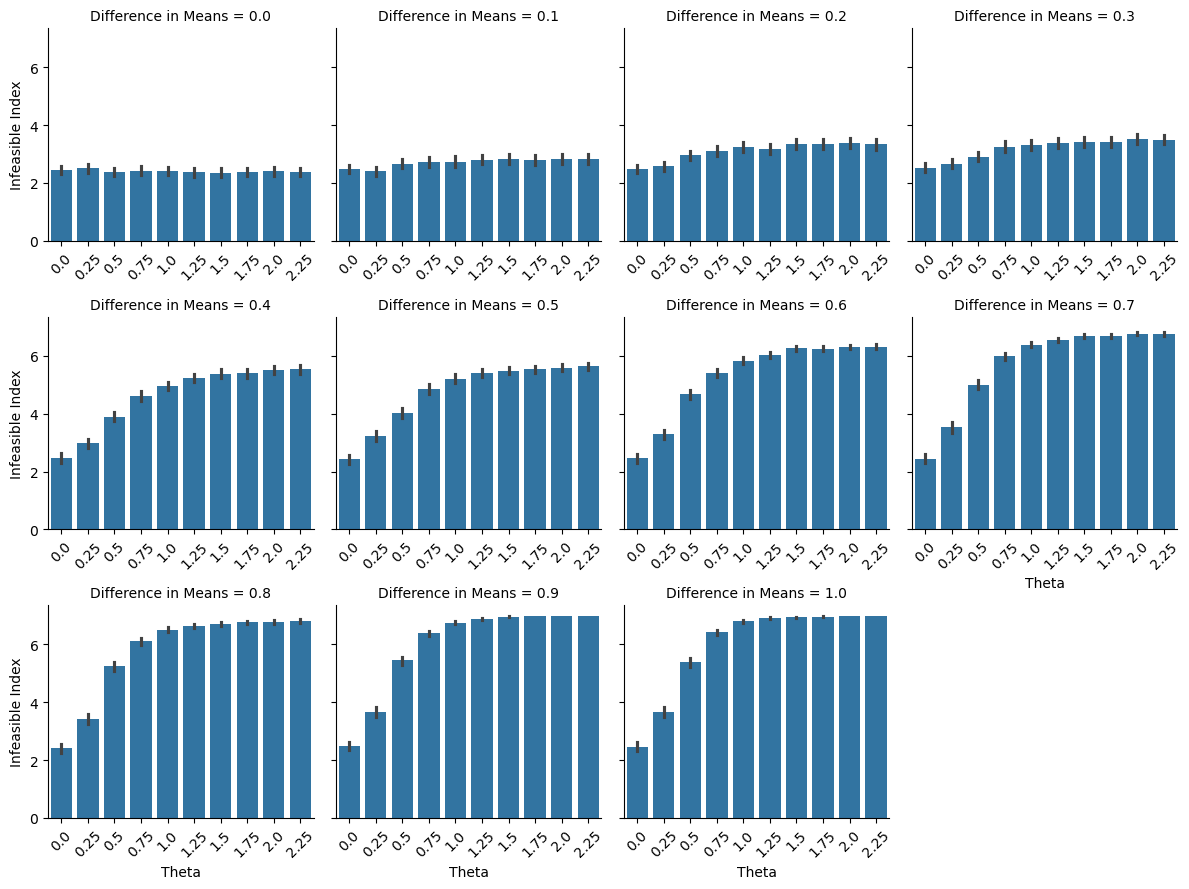

In [30]:
gr = sns.FacetGrid(rmu, col='Difference in Means',col_wrap=4,sharex=False)
gr.map(sns.barplot, 'Theta', 'Infeasible Index', order=theta_range)
for i in range(11):
    gr.facet_axis(0,i).tick_params(axis='x',labelrotation=45)

gr.tight_layout()
gr.savefig('mallows_means_unif_ppf_mean.png')

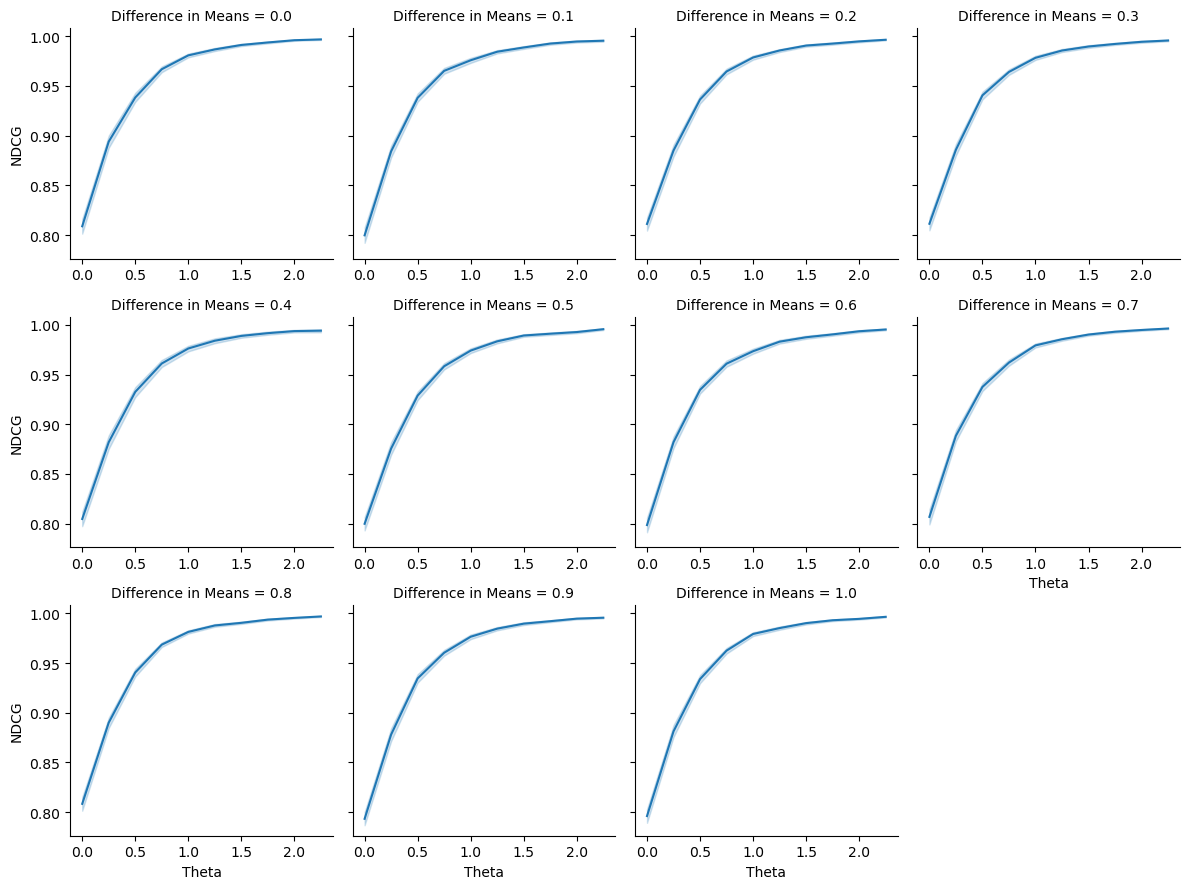

In [31]:
grid = sns.FacetGrid(rmu, col='Difference in Means',col_wrap=4,sharex=False)
grid.map(sns.lineplot, 'Theta', 'NDCG')

grid.savefig('mallows_means_unif_ndcg_mean.png')

## Experiment 3: German Credit dataset

For the ranking of the candidates, we use the **Credit Amount** attribute. We aggregate the binary attributes **S⁢e⁢x** and **A⁢g⁢e** into the **S⁢e⁢x−A⁢g⁢e** protected attribute with four values and consider the information of this attribute as **known**. We evaluate the fairness of the algorithms in terms of a third attribute, named **H⁢o⁢u⁢s⁢i⁢n⁢g**, with three values. We regarded the H⁢o⁢u⁢s⁢i⁢n⁢g attribute as unknown; therefore, it could not be used as information for any algorithm.

In [32]:
# import cvxpy as cp
# import pip
# if not ('GUROBI' in cp.installed_solvers()):
#   pip.main(['install', 'cvxpy[GUROBI]'])
# if not ('SCIP' in cp.installed_solvers()):
#   pip.main(['install', 'cvxpy[SCIP]'])
# cp.installed_solvers()

## IMPORTANT: If a solver is installed, but you see a "Solver _____ is not installed"
## error in the next cell, restart the session and run again

#### Prepare the German Credit Dataset

In [8]:
import pandas as pd
# prepare the German Credit Dataset, rank by `credit amount`, protected attribute - age X sex ###
german = pd.read_csv('german_credit_data.csv')
german = german.drop(['Unnamed: 0', 'Job', 'Saving accounts', 'Checking account', 'Duration', 'Purpose'],axis=1)
# pd.cut() would be overkill here
# bin age
german['Age'] = german['Age'].map(lambda x: '<35' if x < 35 else '>=35')

german_groups =[{'Age': '>=35', 'Sex': 'male'},{'Age': '>=35', 'Sex':'female'},{'Age': '<35', 'Sex': 'male'}, {'Age': '<35', 'Sex': 'female'}]
german_groups_sex = [{'Sex': 'male'}, {'Sex': 'female'}]
german_groups_age = [{'Age': '>=35'}, {'Age': '<35'}]
german_groups_hou = [{'Housing': 'own'}, {'Housing': 'free'}, {'Housing': 'rent'}]
german['Age&Sex'] = german.apply(lambda x: ' '.join([x['Age'], x['Sex']]), axis=1)

german = german.sort_values(by='Credit amount', ascending=False).reset_index(drop=True)
german

,Age,Sex,Housing,Credit amount,Age&Sex
0,<35,female,own,18424,<35 female
1,>=35,male,rent,15945,>=35 male
2,>=35,male,own,15857,>=35 male
3,<35,male,own,15672,<35 male
4,<35,male,own,15653,<35 male
...,...,...,...,...,...
995,<35,female,own,343,<35 female
996,>=35,male,own,339,>=35 male
997,>=35,male,own,338,>=35 male
998,<35,male,rent,276,<35 male


Define the groups

In [9]:
def get_group_props(dataset, groups):
  props = []
  for group in groups:
    q = ' & '.join(
        [f'{s_i}=="{v_i}"' if isinstance(v_i, str) else f'{s_i}=={v_i}'
        for s_i, v_i in group.items()]
        )
    group_size = len(dataset.query(q))
    props.append(group_size/len(dataset))
  return props

props_sex = get_group_props(german, german_groups_sex)
props_age = get_group_props(german, german_groups_age)
props_hou = get_group_props(german, german_groups_hou)

groups = german_groups
props = get_group_props(german, groups)

In [16]:
rec_sizes = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
reranks = {'Mallows': {}, 'Mallows (best sample)': {}, 'ILP':{}, 'DetConstSort': {}, 'AMVIPF' : {}}
rng = np.random.default_rng(seed=0)
m = 0
v = 1
theta=1
mallows_tries = 15
trials = 1 if v == 0 else 15

for r_ in rec_sizes:
  for alg in reranks.keys():
    reranks[alg][r_] = []
  center = prepare_items(german,groups,props,'Credit amount',r_)
  rerank = mallows_sample(theta=theta, s0=center, m=mallows_tries)
  reranks['Mallows (best sample)'][r_] = rerank
  reranks['Mallows'][r_] = rerank
  for j in range(trials):
    rerank = linkedin_alg(items=center,
                          groups = groups,
                          target_prop = props, score_label='Credit amount',
                          r=r_, noise_rng=rng, noise_mean=m, noise_var=v)
    reranks['DetConstSort'][r_].append(rerank)
    try:
      rerank = linprog_alg(center,
                      groups=groups,
                      target_prop=props, score_label='Credit amount',
                      r = r_, solver='SCIP', noise_rng=rng, noise_mean=m, noise_var=v)
      reranks['ILP'][r_].append(rerank)
    except:
      reranks['ILP'][r_] = None
    rerank = ApproxMultiValuedIPF(center,
                                  'Age&Sex',
                                  'Credit amount',
                                  r_,rng,m,v)
    reranks['AMVIPF'][r_].append(rerank)

    # rerank = mallows_sample(theta=theta, s0=prepare_items(german,groups,props,'Credit amount',r))
    # rerank = mallows_sample(theta=theta, s0=prepare_items(german,groups,props,'Credit amount',r_), m=mallows_tries)
    # # reranks['Mallows (best sample)'][r].append(rerank)
    # reranks['Mallows (best sample)'][r_].append(rerank[0])
    # reranks['Mallows'][r_].append(rerank[0])

  print(r_)

10
20
30
40
50
60
70
80
90
100


#### Calculate statistics

In [17]:
res_df = pd.DataFrame(columns=[
    'Algorithm',
    'Number of Items',
    '% P-Fair Positions (Age&Sex)',
    '% P-Fair Positions (Sex)',
    '% P-Fair Positions (Age)',
    '% P-Fair Positions (Housing)',
    'NDCG',
    '% Positions Sat. Min. Representation',
    'Infeasible Index',
    'KT from Center'])

def pick_best(a, f):
  res = [0,0,0]
  for i, x in enumerate(a):
    val = f(x)
    res[2] += val
    if i == 0:
      res[1] = val
    if val > res[1]:
      res[1] = val
      res[0] = i
  res[2] /= (i+1)
  return res

j = 0
for alg in reranks.keys():
  print(alg)
  for r_ in reranks[alg].keys():
    r_rankings = reranks[alg][r_]
    if alg == 'Mallows (best sample)':
      best_ii_total = pick_best(r_rankings, lambda l: -infeasible_index(l, groups, props))
      ii = -best_ii_total[1]
      best_ii_sex = pick_best(r_rankings, lambda l: -infeasible_index(l,german_groups_sex,props_sex))
      ii_sex = -best_ii_sex[1]
      best_ii_age = pick_best(r_rankings, lambda l: -infeasible_index(l,german_groups_age,props_age))
      ii_age = -best_ii_age[1]
      best_ii_hou = pick_best(r_rankings, lambda l: -infeasible_index(l,german_groups_hou,props_hou))
      ii_hou = -best_ii_hou[1]
      best_ii_min = pick_best(r_rankings, lambda l: -infeasible_index(l,groups,props,control_upper=False))
      ii_min = -best_ii_min[1]
      best_ndcg = pick_best(r_rankings, lambda l: ndcg(l['Credit amount'], german['Credit amount']))
      gain = best_ndcg[1]
      best_kt = pick_best(r_rankings,
                            lambda l: -KT(
                                prepare_items(german, groups, props, 'Credit amount',r_).index,
                                l.index))
      kt = -best_kt[1]
      new_row = {'Algorithm': alg,
                      'Number of Items': r_,
                      '% P-Fair Positions (Age&Sex)': 100-ii/r_*100,
                      '% P-Fair Positions (Sex)': 100-ii_sex/r_*100,
                      '% P-Fair Positions (Age)': 100-ii_age/r_*100,
                      '% P-Fair Positions (Housing)': 100-ii_hou/r_*100,
                      '% Positions Sat. Min. Representation': 100-ii_min/r_*100,
                      'NDCG': gain,
                      'Infeasible Index': ii_min,
                'KT from Center': kt}
      res_df.loc[j] = new_row
      j += 1
    else:
      if r_rankings is not None:
        for ranking in r_rankings:
          ii = infeasible_index(ranking, groups = groups, target_prop = props)
          ii_sex = infeasible_index(ranking, groups = german_groups_sex, target_prop = props_sex)
          ii_age = infeasible_index(ranking, groups = german_groups_age, target_prop = props_age)
          ii_hou = infeasible_index(ranking, groups = german_groups_hou, target_prop = props_hou)
          ii_min = infeasible_index(ranking, groups = groups, target_prop = props, control_upper=False)
            # print(100-ii_min/len(ranking)*100)
          kt = KT(prepare_items(german, groups, props, 'Credit amount',r_).index, ranking.index)
          gain = ndcg(ranking['Credit amount'], german['Credit amount'])
          new_row = {'Algorithm': alg,
                      'Number of Items': r_,
                      '% P-Fair Positions (Age&Sex)': 100-ii/r_*100,
                      '% P-Fair Positions (Sex)': 100-ii_sex/r_*100,
                      '% P-Fair Positions (Age)': 100-ii_age/r_*100,
                      '% P-Fair Positions (Housing)': 100-ii_hou/r_*100,
                      '% Positions Sat. Min. Representation': 100-ii_min/r_*100,
                      'NDCG': gain,
                      'Infeasible Index': ii_min,
                'KT from Center': kt}
          res_df.loc[j] = new_row
          j += 1

Mallows
Mallows (best sample)
ILP
DetConstSort
AMVIPF


Save results to csv

In [18]:
save = False

In [19]:
if save:
    import pathlib
    pathlib.Path(f'./plots/theta_{theta}_m_{m}_v_{v}').mkdir(parents=True, exist_ok=True)
    res_df.to_csv(f'./plots/theta_{theta}_m_{m}_v_{v}/res_df.csv')

### Plots!

#### % P-fair

Plot the percent of positions satisfying proportional fairness constraints with respect to different protected attributes.

##### Housing

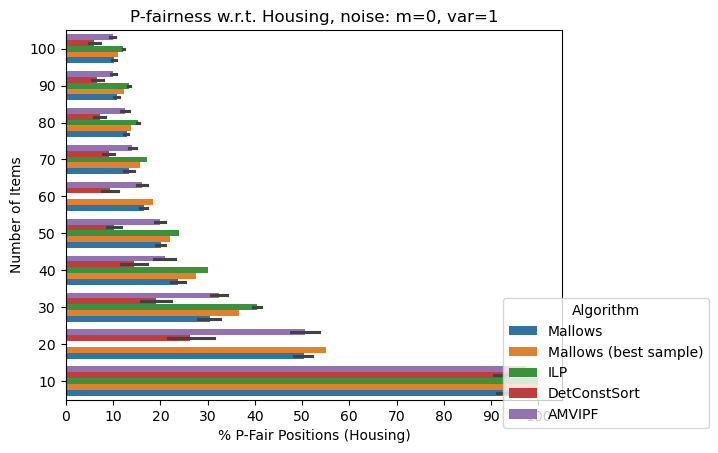

In [21]:
ax = sns.barplot(x = '% P-Fair Positions (Housing)', y='Number of Items',
            errorbar='ci',
            hue = 'Algorithm',data=res_df,
            orient='h')
ax.invert_yaxis()
ax.set_xticks(np.arange(0, 101, 10))
ax.set_xlim(0, 105)
ax.set_title(f'P-fairness w.r.t. Housing, noise: m={m}, var={v}')
sns.move_legend(ax, "center right", bbox_to_anchor=(1.31, 0.1))

fig = ax.get_figure()
if save:
    fig.savefig(f'./plots/theta_{theta}_m_{m}_v_{v}/p_pfair_hou', bbox_inches="tight")

In [107]:
if save:
    res_df=pd.read_csv(f'./plots/theta_{theta}_m_{m}_v_{v}/res_df.csv')

##### Age&Sex

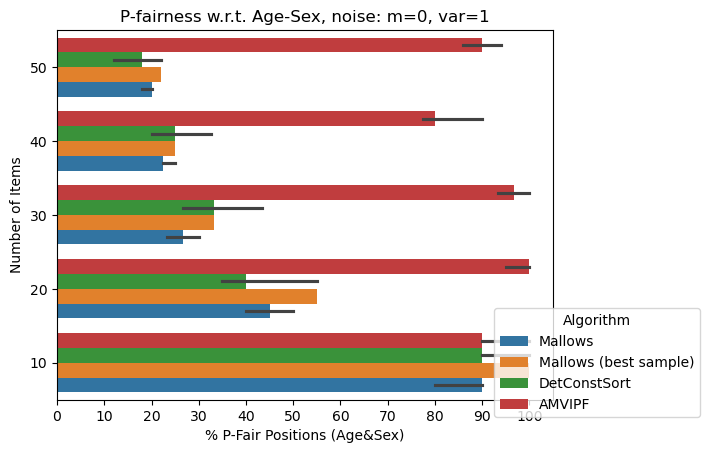

In [45]:
ax = sns.barplot(x = '% P-Fair Positions (Age&Sex)', y='Number of Items',
            errorbar='ci',
            estimator=np.median,
            hue = 'Algorithm',data=res_df,
            orient='h')
ax.invert_yaxis()
ax.set_xticks(np.arange(0, 101, 10))
ax.set_xlim(0, 105)
ax.set_title(f'P-fairness w.r.t. Age-Sex, noise: m={m}, var={v}')
sns.move_legend(ax, "center right", bbox_to_anchor=(1.31, 0.1))

fig = ax.get_figure()
if save:
    fig.savefig(f'./plots/theta_{theta}_m_{m}_v_{v}/p_pfair', bbox_inches="tight")

##### Age

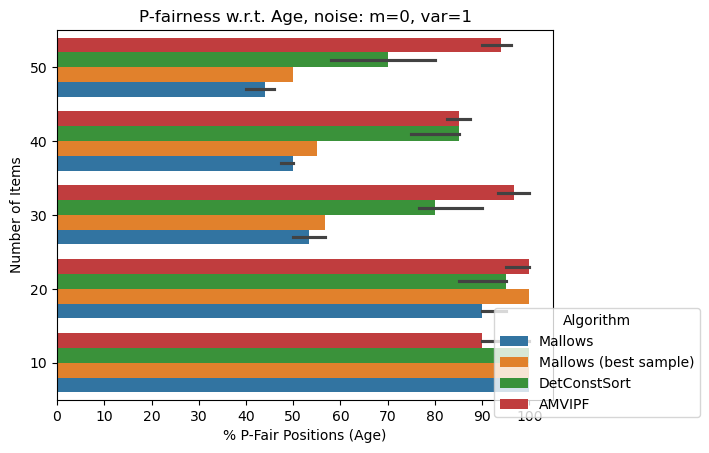

In [46]:
ax = sns.barplot(x = '% P-Fair Positions (Age)', y='Number of Items',
            errorbar='ci',
            estimator=np.median,
            hue = 'Algorithm',data=res_df,
            orient='h')
ax.invert_yaxis()
ax.set_xticks(np.arange(0, 101, 10))
ax.set_xlim(0, 105)
ax.set_title(f'P-fairness w.r.t. Age, noise: m={m}, var={v}')
sns.move_legend(ax, "center right", bbox_to_anchor=(1.31, 0.1))

fig = ax.get_figure()
if save:
    fig.savefig(f'./plots/theta_{theta}_m_{m}_v_{v}/p_pfair_age', bbox_inches="tight")

##### Sex

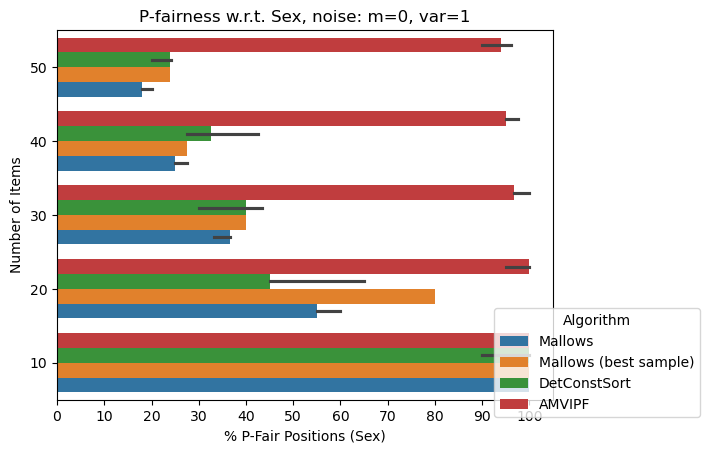

In [47]:
ax = sns.barplot(x = '% P-Fair Positions (Sex)', y='Number of Items',
            errorbar='ci',
            estimator=np.median,
            hue = 'Algorithm',data=res_df,
            orient='h')
ax.invert_yaxis()
ax.set_xticks(np.arange(0, 101, 10))
ax.set_xlim(0, 105)
ax.set_title(f'P-fairness w.r.t. Sex, noise: m={m}, var={v}')
sns.move_legend(ax, "center right", bbox_to_anchor=(1.31, 0.1))

fig = ax.get_figure()
if save:
    fig.savefig(f'./plots/theta_{theta}_m_{m}_v_{v}/p_pfair_sex', bbox_inches="tight")

#### NDCG

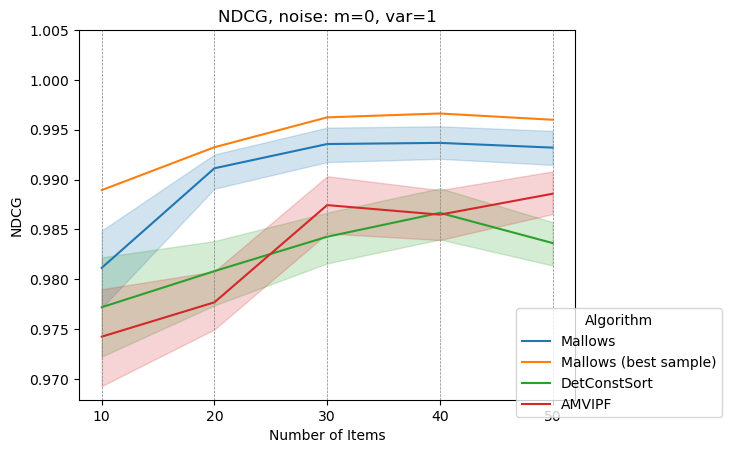

In [48]:
ax = sns.lineplot(x='Number of Items', y='NDCG', hue='Algorithm', data=res_df)
# ax.invert_yaxis()
ax.set_xticks(rec_sizes)
for j in rec_sizes:
  ax.axvline(j, color='gray', ls='--',lw=0.5)
ax.set_ylim(ax.get_ylim()[0], 1.005)
ax.set_title(f'NDCG, noise: m={m}, var={v}')
sns.move_legend(ax, "center right", bbox_to_anchor=(1.31, 0.1))

fig = ax.get_figure()
if save:
  fig.savefig(f'plots/theta_{theta}_m_{m}_v_{v}/ndcg', bbox_inches="tight")

#### KT Divergence from Center

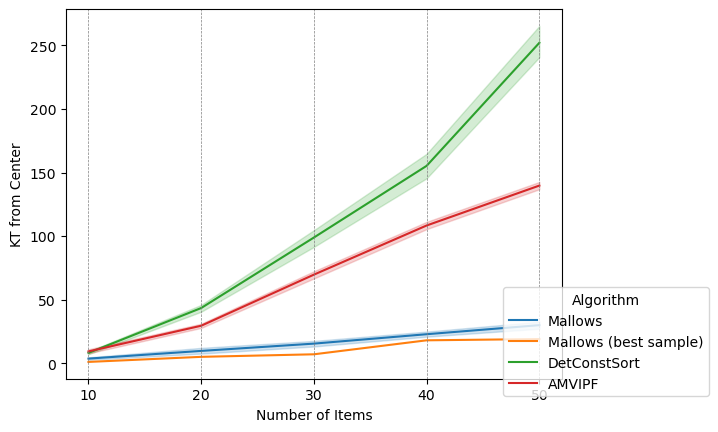

In [113]:
ax = sns.lineplot(x='Number of Items', y='KT from Center', hue='Algorithm', data=res_df)
# ax.invert_yaxis()
ax.set_xticks(rec_sizes)
for j in rec_sizes:
  ax.axvline(j, color='gray', ls='--',lw=0.5)
sns.move_legend(ax, "center right", bbox_to_anchor=(1.31, 0.1))

fig = ax.get_figure()
if save:
  fig.savefig(f'plots/theta_{theta}_m_{m}_v_{v}/kt', bbox_inches="tight")

#### % Satisfying minimal representation (100*length/InfIndex)

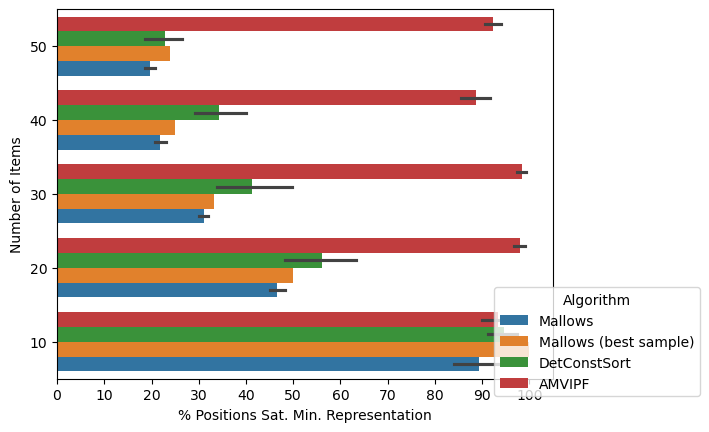

In [114]:
ax = sns.barplot(x = '% Positions Sat. Min. Representation', y='Number of Items',
            errorbar='ci',
            hue = 'Algorithm',data=res_df,
            orient='h')
ax.invert_yaxis()
ax.set_xticks(np.arange(0, 101, 10))
ax.set_xlim(0, 105)
sns.move_legend(ax, "center right", bbox_to_anchor=(1.31, 0.1))

fig = ax.get_figure()
if save:
    fig.savefig(f'plots/theta_{theta}_m_{m}_v_{v}/p_minrepr', bbox_inches="tight")

#### InfeasibleIndex

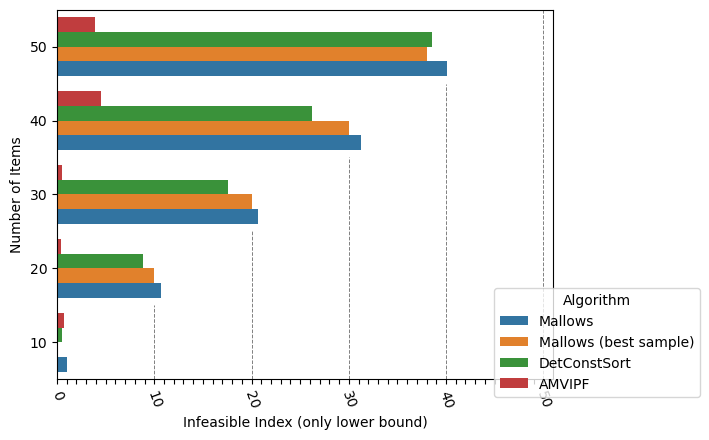

In [115]:
ax = sns.barplot(x = 'Infeasible Index', y='Number of Items',
            errorbar=None,
            hue = 'Algorithm',data=res_df,
            orient='h')
for j, r_ in enumerate(rec_sizes):
  ax.axvline(r_,0,(j+1)/len(rec_sizes), ls='--',lw=0.7, c='gray')
ax.set_xticks(np.arange(0,r_+1,step=10))
ax.invert_yaxis()
ax.set_xticklabels(ax.get_xticklabels(), rotation=-70)
ax.set_xlabel('Infeasible Index (only lower bound)')
ax.set_xticks(range(0, rec_sizes[-1]+1))
ax.set_xlim(0, rec_sizes[-1]+1)
sns.move_legend(ax, "center right", bbox_to_anchor=(1.31, 0.1))

fig = ax.get_figure()
if save:
  fig.savefig(f'plots/theta_{theta}_m_{m}_v_{v}/infind', bbox_inches="tight")

## Not related to the paper: Approximate Mallows Tests

Approximate Mallows Sampling code adapted from https://github.com/ekhiru/top-k-mallows/ under GPL-3.0

Original code is not available (or doesn't work) as a python package

### Compare with exact sampling

In [ ]:
import pandas as pd

def approximate_mallows(center: pd.DataFrame, theta: int):
    center_ind = np.array(center.index)
    sample = mk_sample(m=1, n=len(center_ind), theta=theta, s0=center_ind)[0]
    return center.loc[sample]

In [ ]:
center=pd.Series([1,2,3,4,5,6,7,8])
theta=0
mm = MallowsModelGenerator(theta=theta, sigma0=center)

In [ ]:
n=5000
sum1 = 0
sum2 = 0
list_kt_exact = []
list_kt_approx = []
for j in range(n):
    sample1 = mm.sample(center)
    sample2 = mallows_sample(s0=center, theta=theta)
    kt_exact = KT(sample1, center)
    kt_approx = KT(list(sample2), center)
    sum1 += kt_exact
    sum2 += kt_approx
    list_kt_exact.append(kt_exact)
    list_kt_approx.append(kt_approx)

In [ ]:
plot = sns.histplot({'Exact': list_kt_exact, 'Approximate': list_kt_approx}, multiple='dodge', discrete=True)
leg = plot.get_legend()
leg.set_title(f'KT from Center, len={len(center)},\ntheta={theta}, {n} experiments')
print(f'exact mean KT from center: {sum1/n}')
print(f'approx mean KT from center: {sum2/n}')
plot

## RAPF Paper Doubts

#### Example 3.1

In Example 3.1 from the paper, they give a ranking that they claim satisfies the minimal representation bound - but, as far as I can tell, it does not.

In [54]:
names = ['Molly' ,'Amy', 'Abi', 'Kim', 'Lee', 'Park', 'Kabir', 'Damien', 'Andres', 'Aaliyah', 'Kiara', 'Jazmine']
scores_m1 = [12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
scores_m2 = 13 - np.array([3,2,5,7,9,1,4,6,8,10,11,12])
sen = ['j']*3 + ['m']*4 + ['s'] *5
sex = ['f', 'f', 'f', 'm', 'm', 'm', 'm', 'm', 'm', 'f', 'f', 'f']
pos_ind = np.arange(1,13)
n = len(names)

rapf = pd.DataFrame({'score_m1': scores_m1, 'score_m2': scores_m2, 'sex': sex,
                     'seniority': sen, 'name': names, 'pos_ind': pos_ind},index=names)
rapf_groups = [{'seniority': 'j'}, {'seniority': 'm'}, {'seniority': 's'}]

Count number of violations of the lower bound:

In [91]:
index_ex31 = ['Molly','Amy','Kim','Damien',
              'Abi','Lee','Andres','Park','Aaliyah','Kabir','Kiara','Jazmine']
df_ex31 = rapf.loc[index_ex31]
ii = infeasible_index(df_ex31, rapf_groups, [3/n,4/n,5/n], control_upper=False,verbose=True)
print(f'Infeasible Index (N violations of lower bound): {ii}')

Violation on k=3 by group 2: L: 1.0 Act: 0 U: 2.0
Violation on k=5 by group 2: L: 2.0 Act: 1 U: 3.0
Violation on k=6 by group 2: L: 2.0 Act: 1 U: 3.0
Violation on k=8 by group 2: L: 3.0 Act: 2 U: 4.0
Violation on k=10 by group 2: L: 4.0 Act: 3 U: 5.0
Infeasible Index (N violations of lower bound): 5


#### German Credit

Test the RAPF implementation of DetConstSort on the German Credit dataset.

Define their implementation of DetConstSort (https://github.com/MouinulIslamNJIT/Rank-Aggregation_Proportionate_Fairness/)

In [69]:
import math

def swap(dict,i,j):
    item = dict[i]
    dict[i] = dict[j]
    dict[j] = item

def DetConstSort(S,A,P,kmax, corrected=False):
    counts = {}
    minCounts = {}
    for ai in A:
        counts[ai] = 0
        minCounts[ai] = 0

    rankedAttList = {}
    rankedScoreList = {}
    maxIndices = {}
    lastEmpty = 0
    k = 0

    while lastEmpty <= kmax:
        k = k + 1
        tempMinCounts = {}
        for ai in A:
            tempMinCounts[ai] = math.floor(k * P[ai])
        changedMins = []
        for ai in A:
            if minCounts[ai ] < tempMinCounts[ai] and counts[ai] < len(S[ai]):
                changedMins.append((S[ai][counts[ai]],ai))
        if len(changedMins) != 0:
            changedMins.sort(reverse=True)
        for sai,ai in  changedMins:
            # if lastEmpty == kmax:
            #     break
            rankedAttList[lastEmpty] = ai

            rankedScoreList[lastEmpty] = S[ai][counts[ai]]
            # the error:
            if corrected:
              maxIndices[lastEmpty] = k-1
            else:
              maxIndices[lastEmpty] = k
            start = lastEmpty
            while start > 0 and maxIndices[start - 1] >= start and rankedScoreList[start-1] < rankedScoreList[start]:
                swap(maxIndices,start - 1,start)
                swap(rankedAttList,start - 1, start)
                swap(rankedScoreList,start - 1, start)
                start = start - 1
            counts[ai] = counts[ai] + 1
            lastEmpty = lastEmpty + 1
        minCounts = tempMinCounts
    return (rankedAttList, rankedScoreList)

Note: the paper does not state clearly what attribute was used as the ranking score; here I use `Credit amount`.

In [93]:
# try their implemenetation on German Credit
A = {'male, >=35', 'female, >=35', 'male, <35', 'female, <35'}
S = {}
P = {'male, >=35': 0.355, 'female, >=35': 0.097, 'male, <35': 0.335, 'female, <35': 0.213}
aif_prop = [0.355, 0.097, 0.335, 0.213]
for group in german_groups:
    q = ' & '.join(
        [f'{s_i}=="{v_i}"' if isinstance(v_i, str) else f'{s_i}=={v_i}'
        for s_i, v_i in group.items()]
        )
    S[', '.join(list(group.values())[::-1])] = german.query(q)['Credit amount'].to_list()

r_ = 50
german_ipf = DetConstSort(S, A, P, r_-1, corrected=False)
german_ipf_df = pd.DataFrame()
german_ipf_df['Sex'] = [x.split(', ')[0] for x in german_ipf[0].values()]
german_ipf_df['Age'] = [x.split(', ')[1] for x in german_ipf[0].values()]
german_ipf_df['Credit amount'] = german_ipf[1]
print('N violations of lower or upper representation bounds:')
print(f'Unmodified from paper:{infeasible_index(german_ipf_df, german_groups, aif_prop)}')

german_ipf = DetConstSort(S, A, P, r_-1, corrected=True)
german_ipf_corrected = pd.DataFrame()
german_ipf_corrected['Sex'] = [x.split(', ')[0] for x in german_ipf[0].values()]
german_ipf_corrected['Age'] = [x.split(', ')[1] for x in german_ipf[0].values()]
german_ipf_corrected['Credit amount'] = german_ipf[1]
print(f'Corrected: {infeasible_index(german_ipf_corrected, german_groups, aif_prop)}')

N violations of lower or upper representation bounds:
Unmodified from paper:20
Corrected: 4


In [88]:
# try the implementation from AIF360 on same data

german_aif = linkedin_alg(items=german, groups=german_groups, target_prop=aif_prop, score_label='Credit amount', r=50)
print(f'II of AIF implementation: {infeasible_index(german_aif, german_groups, aif_prop)}')

II of AIF implementation: 4


In [104]:
# try Approximate Multi-Valued IPF on the same data

german_amvipf = ApproxMultiValuedIPF(german,pr_attr_name='Age&Sex', score_attr_name='Credit amount', r=50)
print(f'II of AMVIPF: {infeasible_index(german_amvipf, german_groups, aif_prop)}')

II of AMVIPF: 40


Try random data, as they do in their code:

In [83]:
rng = np.random.default_rng(seed=50)
A = {'a','b','c'}
sizes = {}
#generate S
S={}
for a in A:
    size = rng.integers(20, 200)
    sizes[a] = size
    scoreList = []
    for j in range(0,size):
        score = rng.integers(0, 10000)/10000
        scoreList.append(score)
    scoreList.sort(reverse=True)
    S[a] = scoreList

total = sum(sizes.values())
P = {group: sizes[group]/total for group in A}
# print(S)
# print(A)
# print(P)
# print(total)

dcs = DetConstSort(S, A, P, kmax=70)
res_uncor = pd.DataFrame()
res_uncor['group'] = dcs[0]
res_uncor['score'] = dcs[1]

dcs_cor = DetConstSort(S, A, P, kmax=70, corrected=True)
res_cor = pd.DataFrame()
res_cor['group'] = dcs_cor[0]
res_cor['score'] = dcs_cor[1]

Note: Sometimes the output of the AIF implementation and the corrected RAPF implementation might be very slightly different due to how elements with same score in different groups are sorted

In [84]:
items = pd.DataFrame()
groups = []
scores = []
for a in A:
  groups += [a]*sizes[a]
  scores += S[a]
items['group'] = groups
items['score'] = scores

groups = [{'group': 'a'}, {'group': 'b'}, {'group': 'c'}]

items.sort_values(by='score', ascending=False, inplace=True)
res_aif = linkedin_alg(items=items, groups=groups,target_prop=[P['a'], P['b'], P['c']], score_label='score', r=71)
print('Number of positions NOT satisfying p-fairness:')
print(f'IPF paper, unmodified: {infeasible_index(res_uncor, groups, [P["a"], P["b"], P["c"]])}')
print(f'IPF paper, corrected: {infeasible_index(res_cor, groups, [P["a"], P["b"], P["c"]])}')
print(f'AIF360: {infeasible_index(res_aif, groups, [P["a"], P["b"], P["c"]])}')
# print('NDCG:')
# print(ndcg(res_uncor['score'], items['score']))
# print(ndcg(res_ours['score'], items['score']))

Number of positions NOT satisfying p-fairness:
IPF paper, unmodified: 28
IPF paper, corrected: 7
AIF360: 8
